# Darija Text Classification using  BERT pretrainned models


## Setup and Data Loading
In this section, we:
- Import required libraries
- Load and prepare our Darija dataset
- Set up configuration parameters

In [1]:
import os 
os.chdir('/kaggle/input/ma-datasets') 
current_directory = os.getcwd()
print("Current working directory:", current_directory)
contents = os.listdir()
print("Directory contents:", contents)

Current working directory: /kaggle/input/ma-datasets
Directory contents: ['suf_pref_darija.json', 'stop_words_accum.json', 'set2.csv', 'set7.csv', 'set5.csv', 'Traditional-Arabic.ttf', 'darija_latin_ref.json', 'set4.csv', 'scaped_comments.csv', 'set3.csv', 'cleaned_clustered_data.csv', 'set1.csv']


In [2]:
!nvidia-smi

Sat Dec 21 20:17:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install evaluate
!pip install pandas PyArabic Tashaphyne pydoda Arabic-Stopwords seaborn scikit-learn emoji xgboost lightgbm 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 26.1 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from tashaphyne.stemming import ArabicLightStemmer
import json
import emoji 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import evaluate

In [5]:
df = pd.read_csv("/kaggle/input/dataset/dataset_bert.csv") # not  stemmed


## Data Preprocessing
Key preprocessing steps for Darija text:
- Text cleaning and normalization
- Feature extraction
- Train-test split


In [6]:
darija_alphabet = {
    "gh": "غ",
    "sh": "ش",
    "ch": "ش",
    "ss": "س",
    "kh": "خ",
    "ç": "س",
    "ou": "و",    
    "ei": "ي",    
    "ay": "ي",    
    "ae": "ي",   
    "5": "خ",     
    "2": "ا",    
    "b": "ب",
    "t": "ت",
    "j": "ج",
    "7": "ح",
    "d": "د",
    "r": "ر",
    "z": "ز",
    "s": "س",
    "9": "ق",
    "3": "ع",
    "4": "غ",
    "f": "ف",
    "q": "ك",
    "k": "ك",
    "l": "ل",
    "m": "م",
    "n": "ن",
    "h": "ه",
    "w": "و",
    "y": "ي",
    "g": "ڭ",
    'i': 'ي',
    'ee': 'ي',
    'aa': 'ا',
    'oo': 'و',
    'o': 'و',
    "x": "ش",
}
word_in = [
    "ء", "أ", "إ", "آ", "ؤ", "ئ", "ة", "ى","-", "/", ".", "،", '"', "'", "\\", "?", "؟", "!", "،", "؛",":","#", "@", "&", "=", "¥", "$", "%", "*", "+", "<", ">", "|", "~", "^", 
    "\n", "\t", "\r", " و","ذ", "ظ", "ض", "ص","(", ")", "[", "]", "{", "}", "《", "》", "«", "»"
]

replaced_by = [
    "ا", "ا", "ا", "ا", "ا", "ا", "ه", "ي"," ", "", "", "", "", "", "", " ? ", " ؟ ", " ! ", "", "", "",
    "", "", "", "", "", "", "", "", "", "", "", "", "", ""," ", " ", " ", "",
    "د", "د", "د", "س","", "", "", "", "", "", "", "", "", ""
]

arabic_alphabet = "ابتثجحخدذرزسشصضطظعغفقكلمنهوي"

In [7]:
from pyarabic.araby import strip_diacritics
#remove tashkeel
def removing_tashkeel(word): # useed
          return strip_diacritics(word)

In [8]:
from pyarabic.araby import strip_tatweel

#remove tatweel l2imdad
def removing_tatweel(word): # useed
          return strip_tatweel(word)

In [9]:
from pyarabic.araby import normalize_ligature

#remove ligature hamza , alef 
def removing_ligature(word): # not used 
          return normalize_ligature(word)

In [10]:
# remove underscore
def replace_underscore(word): # useed
          return word.replace("_", " ")

In [11]:
import pyarabic.araby as araby

# remove hamza ambiguity
def remove_ambiguity_hamza(word): # useed
          return araby.normalize_hamza(word)

In [12]:
# romove "AL"
def remove_AL(word): # useed
          return re.sub(r'^ال', '', word)

In [13]:
# remove repeated characters      
def word_remover(word): # useed
            if len(word) == 1 or len(word) == 0 or len(word) >= 13:
                return ""                
            else :
                # print(word)
                for a7rf in arabic_alphabet:
                    if a7rf == 'د' or a7rf == 'ه':
                        word = re.sub(fr'{a7rf}{{3,}}', a7rf * 2, word).strip()
                    else:
                        word = re.sub(fr'{a7rf}+', a7rf, word).strip()
                # print(word) 
                for i in range(len(word)):
                    if word[i] in word_in:
                        index = word_in.index(word[i])
                        word = word[:i] + replaced_by[index] + word[i + 1:]

                return word


In [14]:
# remove emails  
def remove_url(text): # useed
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b',
                  '', text, flags=re.MULTILINE)
    return text      
 

In [15]:
 # remove emails     
def remove_emails(text): # useed
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text, flags=re.MULTILINE)
    return text  

In [16]:
def special_tags_and_ponctuations(text):  # Function to clean special tags
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'&quot;', '', text)  
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\.+', '.', text)

    return text

In [17]:
def remove_html_tags(text):
    text = re.sub(r'<[^>]+>', '', text)
    return text

In [18]:
# hundle emojis
def extend_spletting(items):  # helper function to split items
    spletting = []
    for item in items:
        spletting.extend(item.split())
    return spletting

In [19]:
def emoji_hundler(word):  # helper function to handle emojis
    word = emoji.demojize(word, language='ar')
    word = replace_underscore(word)[1:-1]
    return word

In [20]:
def is_an_emoji(word):
    emoji_pattern = re.compile("["  
                               u"\U0001F680-\U0001F6FF"  # transport and map unicods
                               u"\U0001F1E0-\U0001F1FF"  # flags unicods
                               "]+", flags=re.UNICODE)

    if emoji.is_emoji(word):
        word = emoji_pattern.sub(r'', word)
        return extend_spletting([emoji_hundler(word)])

    elif emoji.purely_emoji(word):
        data_of_emojis = emoji.distinct_emoji_list(word)
        data = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        return extend_spletting(data)

    else:
        text_only = re.sub(r'[^\w\s?!]', '', word)
        data_of_emojis = emoji.distinct_emoji_list(word)
        emojis = [emoji_hundler(emoji_pattern.sub(r'', item)) for item in data_of_emojis]
        
        return [text_only] + extend_spletting(emojis)


In [21]:
# tramslating darija(latin) to daruja(arabic)
def translate_darija_to_arabic(word): # useed
    # print("test")
    word = word.lower()
    if  bool(re.compile(r"[a-z0-9']+").search(word)):
        arabic_word = ""
        i = 0
        while i < len(word):
            # print('sadd')
            if i + 1 < len(word) and word[i:i+2] in darija_alphabet: # Check for 2 lettrs
                arabic_word += darija_alphabet[word[i:i+2]]
                i += 2
            elif word[i] in darija_alphabet:
                arabic_word += darija_alphabet[word[i]]
                i += 1
            else:
                i += 1
        return arabic_word
    return word
      

In [22]:
# remove  number arabic and latin
def number_remov(listy): # useed
    number_pattern = re.compile(r'^[0-9\u0660-\u0669]+$')
    cleaned_list = [item for item in listy if not number_pattern.fullmatch(item)] 
    return cleaned_list   

In [23]:
#stemming arabic words     
def stemming_darija(word):
    # file = "./Data_prep/suf_pref_darija.json" # local run
    file = "suf_pref_darija.json" 

    with open(file, 'r', encoding='utf-8') as json_file:
        suf_pref = json.load(json_file)

    ArListem = ArabicLightStemmer()
    ArListem.set_prefix_list(suf_pref['darija_prefixes'])
    ArListem.set_suffix_list(suf_pref['darija_suffixes'])
    ArListem.light_stem(word)  
    return ArListem.get_stem() 

In [24]:
# "03:44"
def remove_yt_timers(text):
    pattern = r'\b\d{1,2}:\d{2,3}(:\d{2,3})?\b'
    text = re.sub(pattern, '', text)
    return text.strip()

In [25]:

def preproc_arab_sentence(word): # main function for  arab processing tokens
    word = removing_tashkeel(word)
    word = removing_tatweel(word)
    word = remove_AL(word)
    # word = remove_ambiguity_hamza(word)
    word = word_remover(word)
    return word


In [26]:
from pyarabic.araby import tokenize
def tokenize_arab_text(text):
            # with open('./Data_prep/stop_words_accum.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./stop_words_accum.json', 'r', encoding='utf-8') as file:

                stop_words = json.load(file)

            # with open('./Data_prep/darija_latin_ref.json', 'r', encoding='utf-8') as file: #  local run 
            with open('./darija_latin_ref.json', 'r', encoding='utf-8') as file:
                
                darija_latin_ref = json.load(file)
          
            #print(text)
            text = remove_url(text)
            text = remove_emails(text)
            text = replace_underscore(text)
            text = remove_html_tags(text)
            text = remove_yt_timers(text)
            text = special_tags_and_ponctuations(text)
            #tokenization
            print(text)
            words = tokenize(text)
            print(words)
            words = [ translate_darija_to_arabic(word) for word in words if word not in darija_latin_ref]
            print(words)
            words = [is_an_emoji(word) for word in words] 
            words = [item for sublist in words for item in sublist if item]
            words = list(set(words))
            print(words)        
            words = [word for word in words if word not in stop_words]
            print(words)

            words = [preproc_arab_sentence(word) for word in words]

            # print(words)        
            words = [stemming_darija(word) for word in words if word]
            words = number_remov(words)


            # print(words)
            words = ' '.join(words) 
            return words

In [27]:
df.head()

,text,target,text_cleaned
0,ياربي تسترنا يااااربي,1,تسترنا ياربي
1,الله يرحمو ويوسع عليه ويخد حقو لا حول ولا قوه ...,1,متجبر لا حقو يرحمو ويخد وطاغي قوه
2,فلوس لحرام واش اتخرج هانية,0,لحرام اتخرج
3,لاحول ولاقوة الى بالله العلي العظيم علامات الس...,1,لهم عديم ولاقوه لاحول لطفك
4,الفيديو ديما خارج عن العنوان,1,NaN


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          30000 non-null  object
 1   target        30000 non-null  int64 
 2   text_cleaned  28985 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [29]:
df.dropna(inplace=True)

# LLM

In [30]:
df.drop(columns=["text"] , inplace=True)
df.head()


,target,text_cleaned
0,1,تسترنا ياربي
1,1,متجبر لا حقو يرحمو ويخد وطاغي قوه
2,0,لحرام اتخرج
3,1,لهم عديم ولاقوه لاحول لطفك
5,0,معجبونيش


In [31]:
models = ["SI2M-Lab/DarijaBERT-arabizi", "SI2M-Lab/DarijaBERT", "otmangi/MorrBERT"]


In [32]:
results = []
batch_size = 20
lr = 2e-4
num_epochs = 3
max_length = 100

In [33]:
def model_tokenizer_initiater(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) 
    print(model.config)
    return model, tokenizer

def tokenize_func(examples, tokenizer):
    return tokenizer(examples['text_cleaned'], padding="max_length", truncation=True, max_length=max_length)


In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

Evaluating model: SI2M-Lab/DarijaBERT-arabizi


tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/787k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT-arabizi and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "SI2M-Lab/DarijaBERT-arabizi",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 128,
  "max_position_embeddings": 512,
  "model_max_length": 128,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "torch_dtype": "float32",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 110000
}



Map:   0%|          | 0/28985 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.712700,0.692690,0.515665
2,0.701800,0.698389,0.484335
3,0.697700,0.692696,0.515665


{'loss': 0.73, 'grad_norm': 299490.65625, 'learning_rate': 0.00019986477349560514, 'epoch': 0.002028397565922921, 'step': 1}
{'loss': 0.7127, 'grad_norm': 87672.984375, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0, 'step': 493}
{'eval_loss': 0.692689836025238, 'eval_accuracy': 0.5156654210980167, 'eval_runtime': 15.746, 'eval_samples_per_second': 220.945, 'eval_steps_per_second': 5.525, 'epoch': 1.0, 'step': 493}
{'loss': 0.7018, 'grad_norm': 207499.640625, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0, 'step': 986}
{'eval_loss': 0.6983894109725952, 'eval_accuracy': 0.48433457890198334, 'eval_runtime': 15.9278, 'eval_samples_per_second': 218.424, 'eval_steps_per_second': 5.462, 'epoch': 2.0, 'step': 986}
{'loss': 0.6977, 'grad_norm': 170561.15625, 'learning_rate': 0.0, 'epoch': 3.0, 'step': 1479}
{'eval_loss': 0.692696213722229, 'eval_accuracy': 0.5156654210980167, 'eval_runtime': 15.7577, 'eval_samples_per_second': 220.781, 'eval_steps_per_second': 5.521, 'epoch': 3.0,

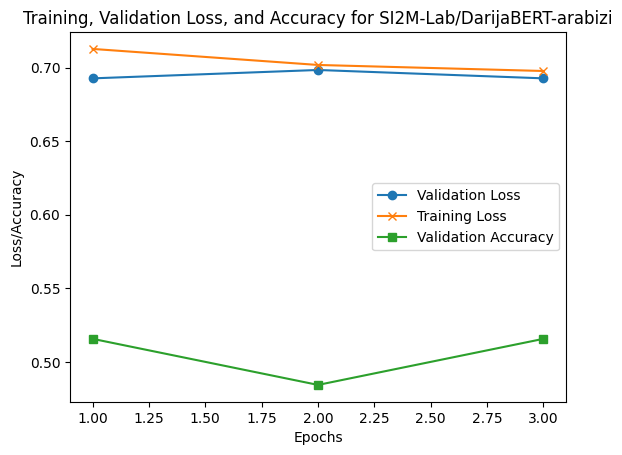

Evaluating model: SI2M-Lab/DarijaBERT


tokenizer_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


vocab.txt:   0%|          | 0.00/879k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


model.safetensors:   0%|          | 0.00/836M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "SI2M-Lab/DarijaBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 128,
  "max_position_embeddings": 512,
  "model_max_length": 128,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 80000
}



Map:   0%|          | 0/28985 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.713800,0.692192,0.501006
2,0.700300,0.694453,0.501006
3,0.697700,0.693384,0.498994


{'loss': 0.6889, 'grad_norm': 165023.1875, 'learning_rate': 0.00019986477349560514, 'epoch': 0.002028397565922921, 'step': 1}
{'loss': 0.7138, 'grad_norm': 345711.8125, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0, 'step': 493}
{'eval_loss': 0.6921917796134949, 'eval_accuracy': 0.5010060362173038, 'eval_runtime': 15.0624, 'eval_samples_per_second': 230.972, 'eval_steps_per_second': 5.776, 'epoch': 1.0, 'step': 493}
{'loss': 0.7003, 'grad_norm': 215775.890625, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0, 'step': 986}
{'eval_loss': 0.6944532990455627, 'eval_accuracy': 0.5010060362173038, 'eval_runtime': 15.2459, 'eval_samples_per_second': 228.193, 'eval_steps_per_second': 5.706, 'epoch': 2.0, 'step': 986}
{'loss': 0.6977, 'grad_norm': 214406.515625, 'learning_rate': 0.0, 'epoch': 3.0, 'step': 1479}
{'eval_loss': 0.6933836340904236, 'eval_accuracy': 0.49899396378269617, 'eval_runtime': 15.279, 'eval_samples_per_second': 227.698, 'eval_steps_per_second': 5.694, 'epoch': 3

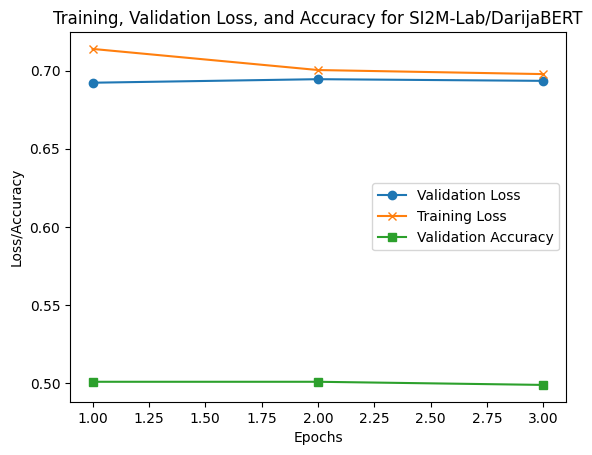

Evaluating model: otmangi/MorrBERT


tokenizer_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/462k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at otmangi/MorrBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "otmangi/MorrBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 52000
}



Map:   0%|          | 0/28985 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.576000,0.613203,0.728945
2,0.522100,0.591587,0.724346
3,0.499400,0.603519,0.716010


{'loss': 0.6577, 'grad_norm': 183035.484375, 'learning_rate': 0.00019986477349560514, 'epoch': 0.002028397565922921, 'step': 1}
{'loss': 0.576, 'grad_norm': 248117.609375, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0, 'step': 493}
{'eval_loss': 0.6132030487060547, 'eval_accuracy': 0.7289450991664271, 'eval_runtime': 14.4683, 'eval_samples_per_second': 240.457, 'eval_steps_per_second': 6.013, 'epoch': 1.0, 'step': 493}
{'loss': 0.5221, 'grad_norm': 112351.96875, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0, 'step': 986}
{'eval_loss': 0.5915873050689697, 'eval_accuracy': 0.7243460764587525, 'eval_runtime': 14.7369, 'eval_samples_per_second': 236.073, 'eval_steps_per_second': 5.904, 'epoch': 2.0, 'step': 986}
{'loss': 0.4994, 'grad_norm': 48105.6640625, 'learning_rate': 0.0, 'epoch': 3.0, 'step': 1479}
{'eval_loss': 0.6035191416740417, 'eval_accuracy': 0.7160103478010923, 'eval_runtime': 14.7522, 'eval_samples_per_second': 235.829, 'eval_steps_per_second': 5.897, 'epoch':

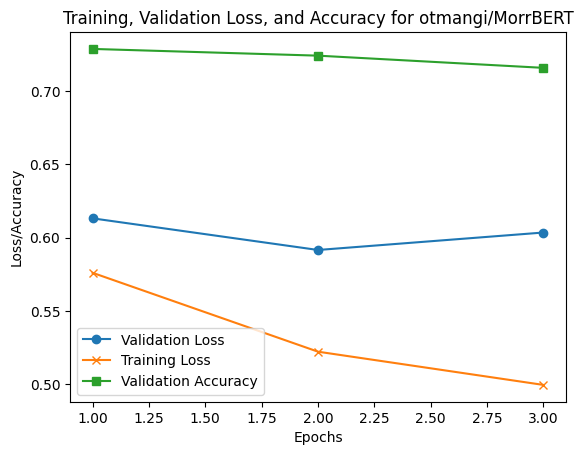

In [36]:
for mod in models:
    print(f"Evaluating model: {mod}")
    
    model_result = {"model_name": mod}
    model, tokenizer = model_tokenizer_initiater(mod)
    
    dataset = Dataset.from_pandas(df)
    tokenized_dataset = dataset.map(
        lambda examples: tokenize_func(examples, tokenizer), 
        batched=True
    )
    tokenized_dataset = tokenized_dataset.rename_column("target", "labels")
    
    split_dataset = tokenized_dataset.train_test_split(test_size=0.2, shuffle=True)
    train_dataset, cv_dataset = split_dataset["train"].train_test_split(test_size=0.15, shuffle=True).values()

    trainerArgs = TrainingArguments(
        output_dir="/kaggle/working/results",
        eval_strategy="epoch",
        logging_dir='/kaggle/working/logs', 
        logging_strategy="epoch",  
        logging_first_step=True, 
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        save_strategy="epoch",
        report_to="none",
        fp16=True,
        load_best_model_at_end=True,
    )
    
    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=cv_dataset,
        tokenizer=tokenizer, 
        args=trainerArgs,
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    
    logs = trainer.state.log_history
    
    train_loss = []
    eval_loss = []
    eval_accuracy = []

    for log in logs:
        print(log)  # Inspect the log structure
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_accuracy' in log:  # Capture accuracy if present
            eval_accuracy.append(log['eval_accuracy'])
    
    if train_loss: 
        train_loss.pop(0)  
    
    epochs = range(1, len(eval_loss) + 1)  
    plt.plot(epochs, eval_loss, label="Validation Loss", marker='o')
    plt.plot(epochs, train_loss, label="Training Loss", marker='x')
    if eval_accuracy:  # Plot accuracy if available
        plt.plot(epochs, eval_accuracy, label="Validation Accuracy", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.title(f"Training, Validation Loss, and Accuracy for {mod}")
    plt.legend()
    plt.show()
    
    model_result["metrics"] = {
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "eval_accuracy": eval_accuracy if eval_accuracy else []
    }
    results.append(model_result)


In [37]:
for model_result in results:
    model_name = model_result["model_name"]
    metrics = model_result["metrics"]
    
    best_accuracy = max(metrics["eval_accuracy"])
    model_result["best_accuracy"] = best_accuracy

    print(f"Best accuracy for {model_name}: {best_accuracy:.4f}")

print("All model evaluations completed:")
print(results)

Best accuracy for SI2M-Lab/DarijaBERT-arabizi: 0.5157
Best accuracy for SI2M-Lab/DarijaBERT: 0.5010
Best accuracy for otmangi/MorrBERT: 0.7289
All model evaluations completed:
[{'model_name': 'SI2M-Lab/DarijaBERT-arabizi', 'metrics': {'train_loss': [0.7127, 0.7018, 0.6977], 'eval_loss': [0.692689836025238, 0.6983894109725952, 0.692696213722229], 'eval_accuracy': [0.5156654210980167, 0.48433457890198334, 0.5156654210980167]}, 'best_accuracy': 0.5156654210980167}, {'model_name': 'SI2M-Lab/DarijaBERT', 'metrics': {'train_loss': [0.7138, 0.7003, 0.6977], 'eval_loss': [0.6921917796134949, 0.6944532990455627, 0.6933836340904236], 'eval_accuracy': [0.5010060362173038, 0.5010060362173038, 0.49899396378269617]}, 'best_accuracy': 0.5010060362173038}, {'model_name': 'otmangi/MorrBERT', 'metrics': {'train_loss': [0.576, 0.5221, 0.4994], 'eval_loss': [0.6132030487060547, 0.5915873050689697, 0.6035191416740417], 'eval_accuracy': [0.7289450991664271, 0.7243460764587525, 0.7160103478010923]}, 'best_ac

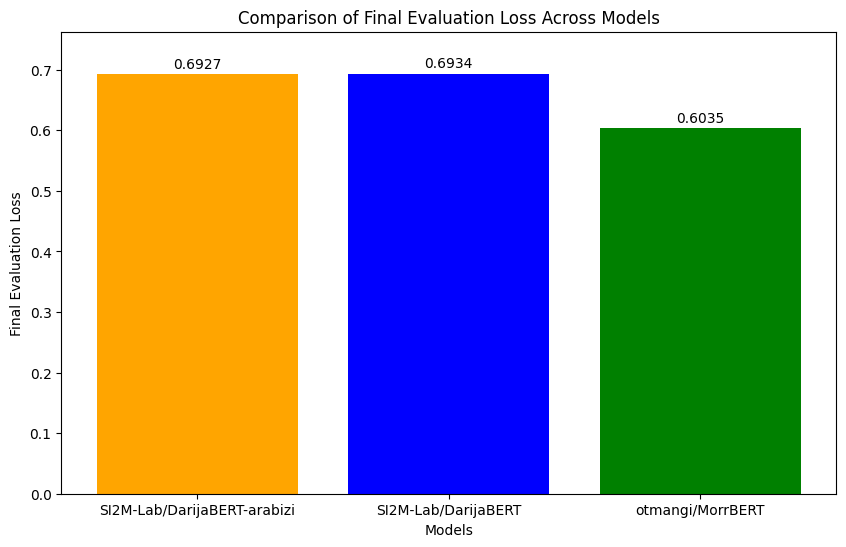

In [38]:
import matplotlib.pyplot as plt

accuracy_comparison = {}
loss_comparison = {}

for i, result in enumerate(results):
    model_name = result["model_name"]
    eval_loss = result["metrics"]["eval_loss"]  
    loss_comparison[model_name] = eval_loss[-1] 

loss_model_names = list(loss_comparison.keys())
losses = list(loss_comparison.values())

plt.figure(figsize=(10, 6))
plt.bar(loss_model_names, losses, color=['orange', 'blue', 'green'])
plt.xlabel("Models")
plt.ylabel("Final Evaluation Loss")
plt.title("Comparison of Final Evaluation Loss Across Models")
plt.ylim(0, max(losses) * 1.1) 
for i, loss in enumerate(losses):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center', fontsize=10)
plt.show()


In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = ["كايبقا حليوة من صناع روابا فالمغرب هادشي كلشي عارفو وشافو بسبابو شفنا تطور كبير فراب المغربي تحياتي ليه من القلب "]

for model_name in models:
    model, tokenizer = model_tokenizer_initiater(model_name)
    
    model = model.to(device)
    
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1)
    
    print(f"Predicted class using {model_name}: {predicted_class.item()}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT-arabizi and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "SI2M-Lab/DarijaBERT-arabizi",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 128,
  "max_position_embeddings": 512,
  "model_max_length": 128,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "torch_dtype": "float32",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 110000
}



The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Predicted class using SI2M-Lab/DarijaBERT-arabizi: 1


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "SI2M-Lab/DarijaBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 128,
  "max_position_embeddings": 512,
  "model_max_length": 128,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 80000
}

Predicted class using SI2M-Lab/DarijaBERT: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at otmangi/MorrBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "otmangi/MorrBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 52000
}

Predicted class using otmangi/MorrBERT: 1
